In [ ]:
from ipywidgets import IntProgress
from IPython.display import display
import time

from covid19_vulnerabilidad_mex.datos import *
from covid19_vulnerabilidad_mex.vulnerabilidad import *

import pandas as pd
import geopandas as gpd

import glob
import os
import matplotlib.pyplot as plt
import numpy as np

from datetime import timedelta
import datetime
from datetime import timedelta, date, datetime

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_decomposition import PLSRegression

import seaborn as sns
import imageio
from pygifsicle import optimize

In [ ]:
plt.style.use('ggplot')

In [ ]:
%load_ext autoreload
%autoreload 2

Bajo los últimos dos días de datos (creo que sólo necesito el último realmente)

In [ ]:
actualizar_datos_salud(fecha_inicio='18-02-2021')

Bajando datos 25.02.2021
Bajando datos 26.02.2021
Bajando datos 27.02.2021


Fijo las variables de análisis

* fecha de análisis
* método
* ventana

In [ ]:
antier = date.today() - timedelta(days=2)
fecha_analisis = antier - timedelta(weeks=2)
fecha_analisis = pd.to_datetime(fecha_analisis)
metodo = 'PLS'
ventana_dias = 28
inicio = pd.to_datetime('20-05-01', yearfirst=True)
fin = antier - timedelta(days=7)

## Cargo los datos

Aquí es donde se le pegan las variables

In [ ]:
covid_municipal = serie_covid_indicadores_municipales(antier.strftime('%y%m%d'),
                                                      acumulativa=False,
                                                      dias=ventana_dias,
                                                      indicadores='datos/municipios/indicadores.csv')
covid_municipal[['conteo', 'defunciones']] = covid_municipal[[f'conteo_{ventana_dias}dias',
                                                              f'defunciones_{ventana_dias}dias']]


In [ ]:
covid_municipal = covid_municipal.drop(columns=[f'conteo_{ventana_dias}dias',
                                   f'defunciones_{ventana_dias}dias'])                                                              
covid_municipal = agregar_tasas_municipales(covid_municipal)
covid_municipal.head()

FECHA_INGRESO ENTIDAD_RES CLAVE_ENTIDAD_RES MUNICIPIO_RES  \
0     2020-01-28      PUEBLA                21   XOCHIAPULCO   
7     2020-01-29      PUEBLA                21   XOCHIAPULCO   
12    2020-01-30      PUEBLA                21   XOCHIAPULCO   
17    2020-01-31      PUEBLA                21   XOCHIAPULCO   
20    2020-02-01      PUEBLA                21   XOCHIAPULCO   

   CLAVE_MUNICIPIO_RES            RESULTADO  conteo  defunciones  \
0                21200  Positivo SARS-CoV-2     0.0          0.0   
7                21200  Positivo SARS-CoV-2     0.0          0.0   
12               21200  Positivo SARS-CoV-2     0.0          0.0   
17               21200  Positivo SARS-CoV-2     0.0          0.0   
20               21200  Positivo SARS-CoV-2     0.0          0.0   

                                             geometry  pt_2015  ...  \
0   POLYGON ((-97.61567 19.91635, -97.64359 19.904...     3357  ...   
7   POLYGON ((-97.61567 19.91635, -97.64359 19.904...     3357  ...   
12  POLYGON ((-97.61567 19.91635, -97.64359 19.904...     3357  ...   
17  POLYGON ((-97.61567 19.91635, -97.64359 19.904...     3357  ...   
20  POLYGON ((-97.61567 19.91635, -97.64359 19.904...     3357  ...   

    pct_obesidad  pct_hipertension  pct_diabetes  total_camas_publicos  \
0      16.157614         19.998411      9.384201                  5310   
7      16.157614         19.998411      9.384201                  5310   
12     16.157614         19.998411      9.384201                  5310   
17     16.157614         19.998411      9.384201                  5310   
20     16.157614         19.998411      9.384201                  5310   

    total_camas_privados  total_hospitales_publicos  \
0                   3120                         97   
7                   3120                         97   
12                  3120                         97   
17                  3120                         97   
20                  3120                         97   

    total_hospitales_privados  covid_confirmados_100k  covid_defun_100k  \
0                         343                     0.0               0.0   
7                         343                     0.0               0.0   
12                        343                     0.0               0.0   
17                        343                     0.0               0.0   
20                        343                     0.0               0.0   

    tasa_covid_letal  
0                NaN  
7                NaN  
12               NaN  
17               NaN  
20               NaN  

[5 rows x 77 columns]

## Letalidad como variable de respuesta

La suguiente celda tiene todo el código para ajustar un modelo de vulnerabilidad en general.

In [ ]:
modelos_letalidad, serie_vulnerabilidad_letalidad = periodo_vulnerabilidad_con_dataframe(covid_municipal,
                                                                     inicio,
                                                                     fin, min_casos=10)
serie_vulnerabilidad_letalidad = agregar_vulnerabilidad_entidades(serie_vulnerabilidad_letalidad,
                                                                   'tasa_covid_letal')
serie_vulnerabilidad_letalidad = agregar_vulnerabilidad_entidades(serie_vulnerabilidad_letalidad, 'valor_tasa_covid_letal')
vulnerabilidad_pls_letalidad = serie_vulnerabilidad_letalidad[serie_vulnerabilidad_letalidad.modelo == metodo]

IntProgress(value=0, max=295)

In [ ]:
modelos_letalidad.to_csv(f"output/modelos_letalidad_{date.today().strftime('%Y-%m-%d')}.csv")
vulnerabilidad_pls_letalidad.to_csv(f"output/serie_vulnerabilidad_letalidad_{date.today().strftime('%Y-%m-%d')}.csv")


### Grafica de la evolución de la vulnerabilidad

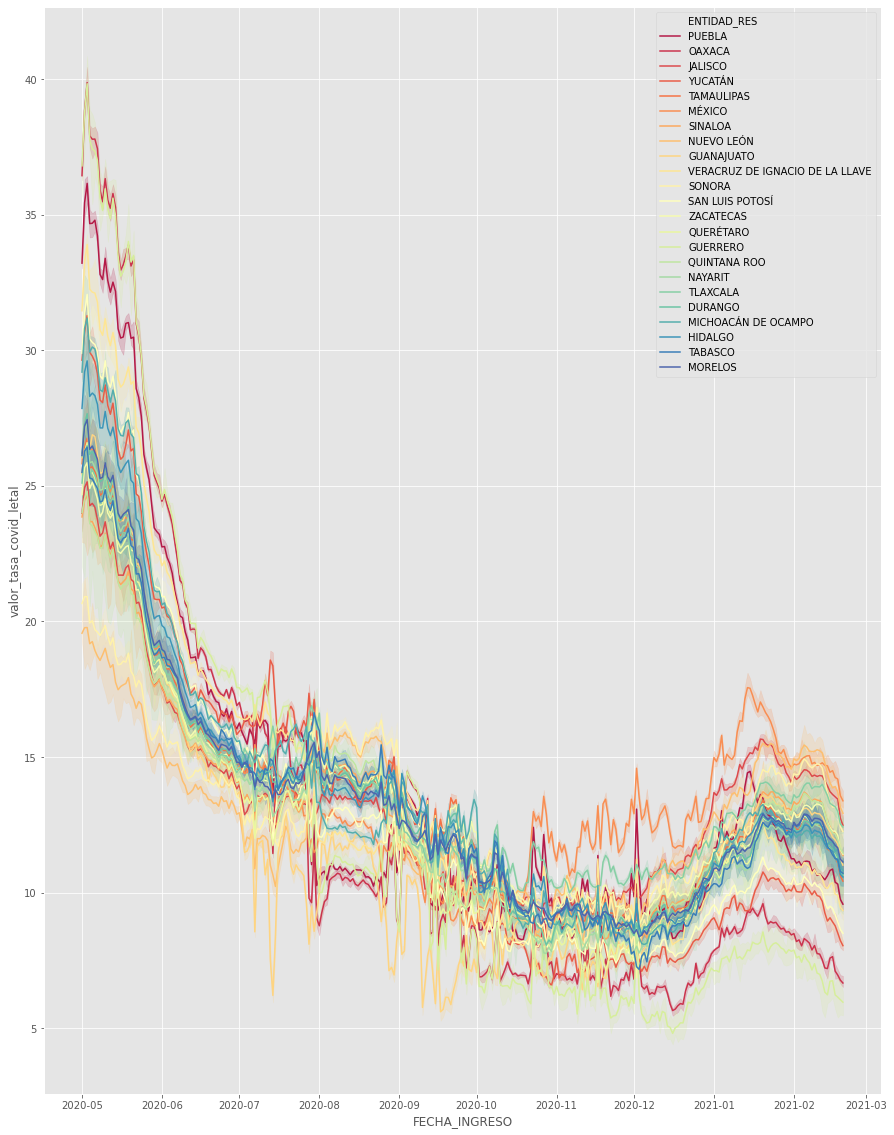

In [ ]:
fig, ax = plt.subplots(figsize=(15, 20))

sns.lineplot(data=vulnerabilidad_pls_letalidad,
             x='FECHA_INGRESO', y=f'valor_tasa_covid_letal',
             hue='ENTIDAD_RES', palette='Spectral',
             n_boot=10)

## Mortalidad como variable de respuesta

In [ ]:
modelos_mortalidad, serie_vulnerabilidad_mortalidad = periodo_vulnerabilidad_con_dataframe(covid_municipal,
                                                                     inicio,
                                                                     fin,
                                                                     columna='covid_defun_100k',
                                                                     min_casos=10)
serie_vulnerabilidad_mortalidad = agregar_vulnerabilidad_entidades(serie_vulnerabilidad_mortalidad,
                                                                   'valor_covid_defun_100k')
vulnerabilidad_pls_mortalidad = serie_vulnerabilidad_mortalidad[serie_vulnerabilidad_mortalidad.modelo == metodo]                                                                   

IntProgress(value=0, max=292)

In [ ]:
modelos_mortalidad.to_csv(f"output/modelos_mortalidad_{date.today().strftime('%Y-%m-%d')}.csv")
vulnerabilidad_pls_mortalidad.to_csv(f"output/serie_vulnerabilidad_mortalidad_{date.today().strftime('%Y-%m-%d')}.csv")

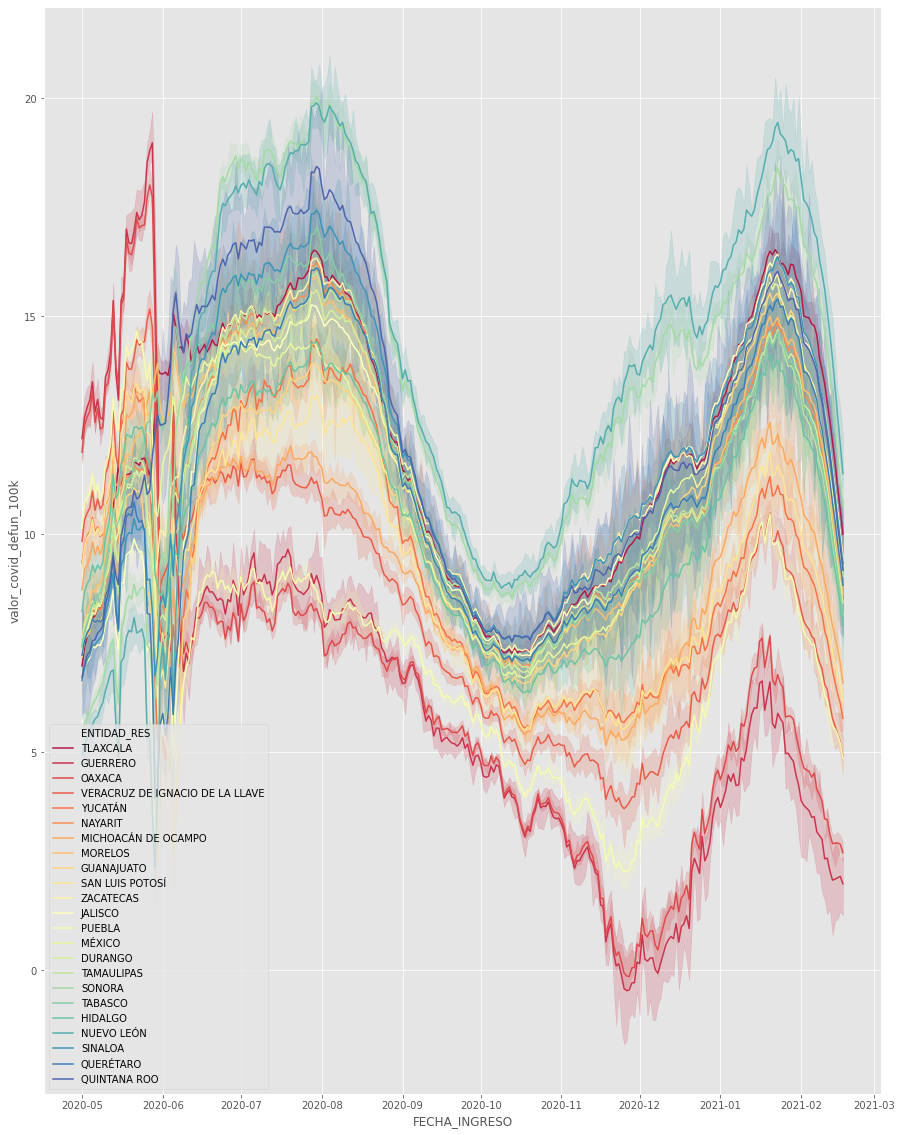

In [ ]:
fig, ax = plt.subplots(figsize=(15, 20))

sns.lineplot(data=vulnerabilidad_pls_mortalidad,
             x='FECHA_INGRESO', y=f'valor_covid_defun_100k',
             hue='ENTIDAD_RES', palette='Spectral',
             n_boot=10)

## Casos confirmados como variable de Respuesta

In [ ]:
modelos_casos, serie_vulnerabilidad_casos = periodo_vulnerabilidad_con_dataframe(covid_municipal,
                                                                     inicio,
                                                                     fin,
                                                                     columna='covid_confirmados_100k',
                                                                     min_casos=10)
serie_vulnerabilidad_casos = agregar_vulnerabilidad_entidades(serie_vulnerabilidad_casos,
                                                                   'valor_covid_confirmados_100k')
vulnerabilidad_pls_casos = serie_vulnerabilidad_casos[serie_vulnerabilidad_casos.modelo == metodo]                                                                     

IntProgress(value=0, max=292)

In [ ]:
modelos_casos.to_csv(f"output/modelos_casos_{date.today().strftime('%Y-%m-%d')}.csv")
vulnerabilidad_pls_casos.to_csv(f"output/serie_vulnerabilidad_casos_{date.today().strftime('%Y-%m-%d')}.csv")

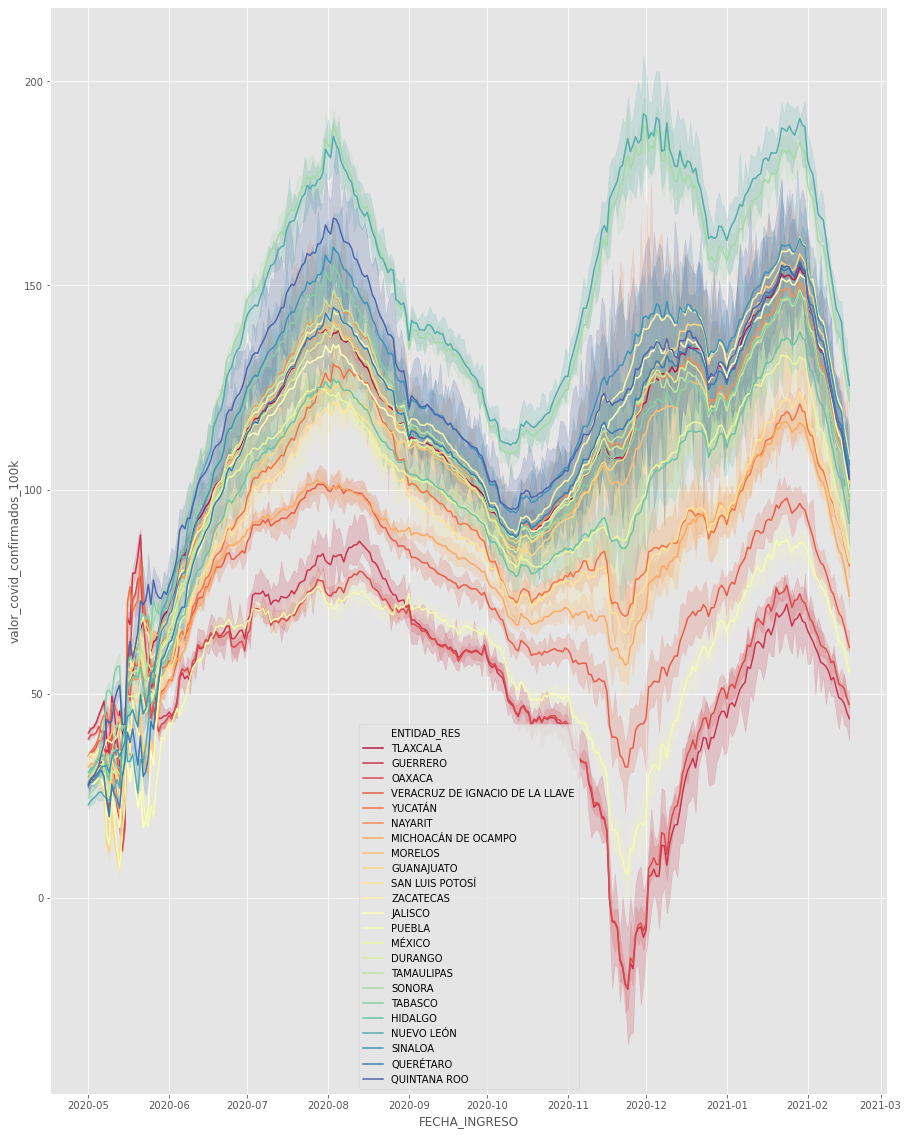

In [ ]:
fig, ax = plt.subplots(figsize=(15, 20))
sns.lineplot(data=vulnerabilidad_pls_casos,
             x='FECHA_INGRESO', y=f'valor_covid_confirmados_100k',
             hue='ENTIDAD_RES', palette='Spectral',
             n_boot=10)

## Comparación de los resultados

Para comparar los resultados de losmodelos ajustados con diferentes variables de respuesta, vamosa reescalar los valores obtenidos en cada caso de forma que siempre varien entre 0 y 1 

In [ ]:
vulnerabilidad_pls_casos['vulnerabilidad_casos_normalizada'] = (vulnerabilidad_pls_casos['valor_covid_confirmados_100k'] -
                                                                vulnerabilidad_pls_casos['valor_covid_confirmados_100k'].min())/(vulnerabilidad_pls_casos['valor_covid_confirmados_100k'].max() -
                                                                                                                                 vulnerabilidad_pls_casos['valor_covid_confirmados_100k'].min())
vulnerabilidad_pls_letalidad['vulnerabilidad_letalidad_normalizada'] = (vulnerabilidad_pls_letalidad['valor_tasa_covid_letal'] -
                                                                vulnerabilidad_pls_letalidad['valor_tasa_covid_letal'].min())/(vulnerabilidad_pls_letalidad['valor_tasa_covid_letal'].max() -
                                                                                                                                 vulnerabilidad_pls_letalidad['valor_tasa_covid_letal'].min())
vulnerabilidad_pls_mortalidad['vulnerabilidad_mortalidad_normalizada'] = (vulnerabilidad_pls_mortalidad['valor_covid_defun_100k'] -
                                                                vulnerabilidad_pls_mortalidad['valor_covid_defun_100k'].min())/(vulnerabilidad_pls_mortalidad['valor_covid_defun_100k'].max() -
                                                                                                                                 vulnerabilidad_pls_mortalidad['valor_covid_defun_100k'].min())


Comparemos la evolución de las series de tiempo

In [ ]:
compara_df = pd.concat([vulnerabilidad_pls_letalidad,
                        vulnerabilidad_pls_mortalidad[['vulnerabilidad_mortalidad_normalizada']],
                        vulnerabilidad_pls_casos[['vulnerabilidad_casos_normalizada']],], axis=1)
compara_df = compara_df[['FECHA_INGRESO', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'vulnerabilidad_letalidad_normalizada',
                         'vulnerabilidad_mortalidad_normalizada', 'vulnerabilidad_casos_normalizada']]
compara_df = compara_df.melt(id_vars=['FECHA_INGRESO', 'ENTIDAD_RES', 'MUNICIPIO_RES'],
                             var_name="variable",
                             value_name="Valor")
compara_df.head()


FECHA_INGRESO                      ENTIDAD_RES  \
0    2020-05-01                         TLAXCALA   
1    2020-05-01                         GUERRERO   
2    2020-05-01                           OAXACA   
3    2020-05-01  VERACRUZ DE IGNACIO DE LA LLAVE   
4    2020-05-01                         GUERRERO   

                             MUNICIPIO_RES  \
0  ZILTLALTÉPEC DE TRINIDAD SÁNCHEZ SANTOS   
1                                  ARCELIA   
2           CHIQUIHUITLÁN DE BENITO JUÁREZ   
3                                 HUATUSCO   
4                        TÉCPAN DE GALEANA   

                               variable     Valor  
0  vulnerabilidad_letalidad_normalizada  0.614369  
1  vulnerabilidad_letalidad_normalizada  0.546177  
2  vulnerabilidad_letalidad_normalizada  0.711932  
3  vulnerabilidad_letalidad_normalizada  0.553941  
4  vulnerabilidad_letalidad_normalizada  0.563876

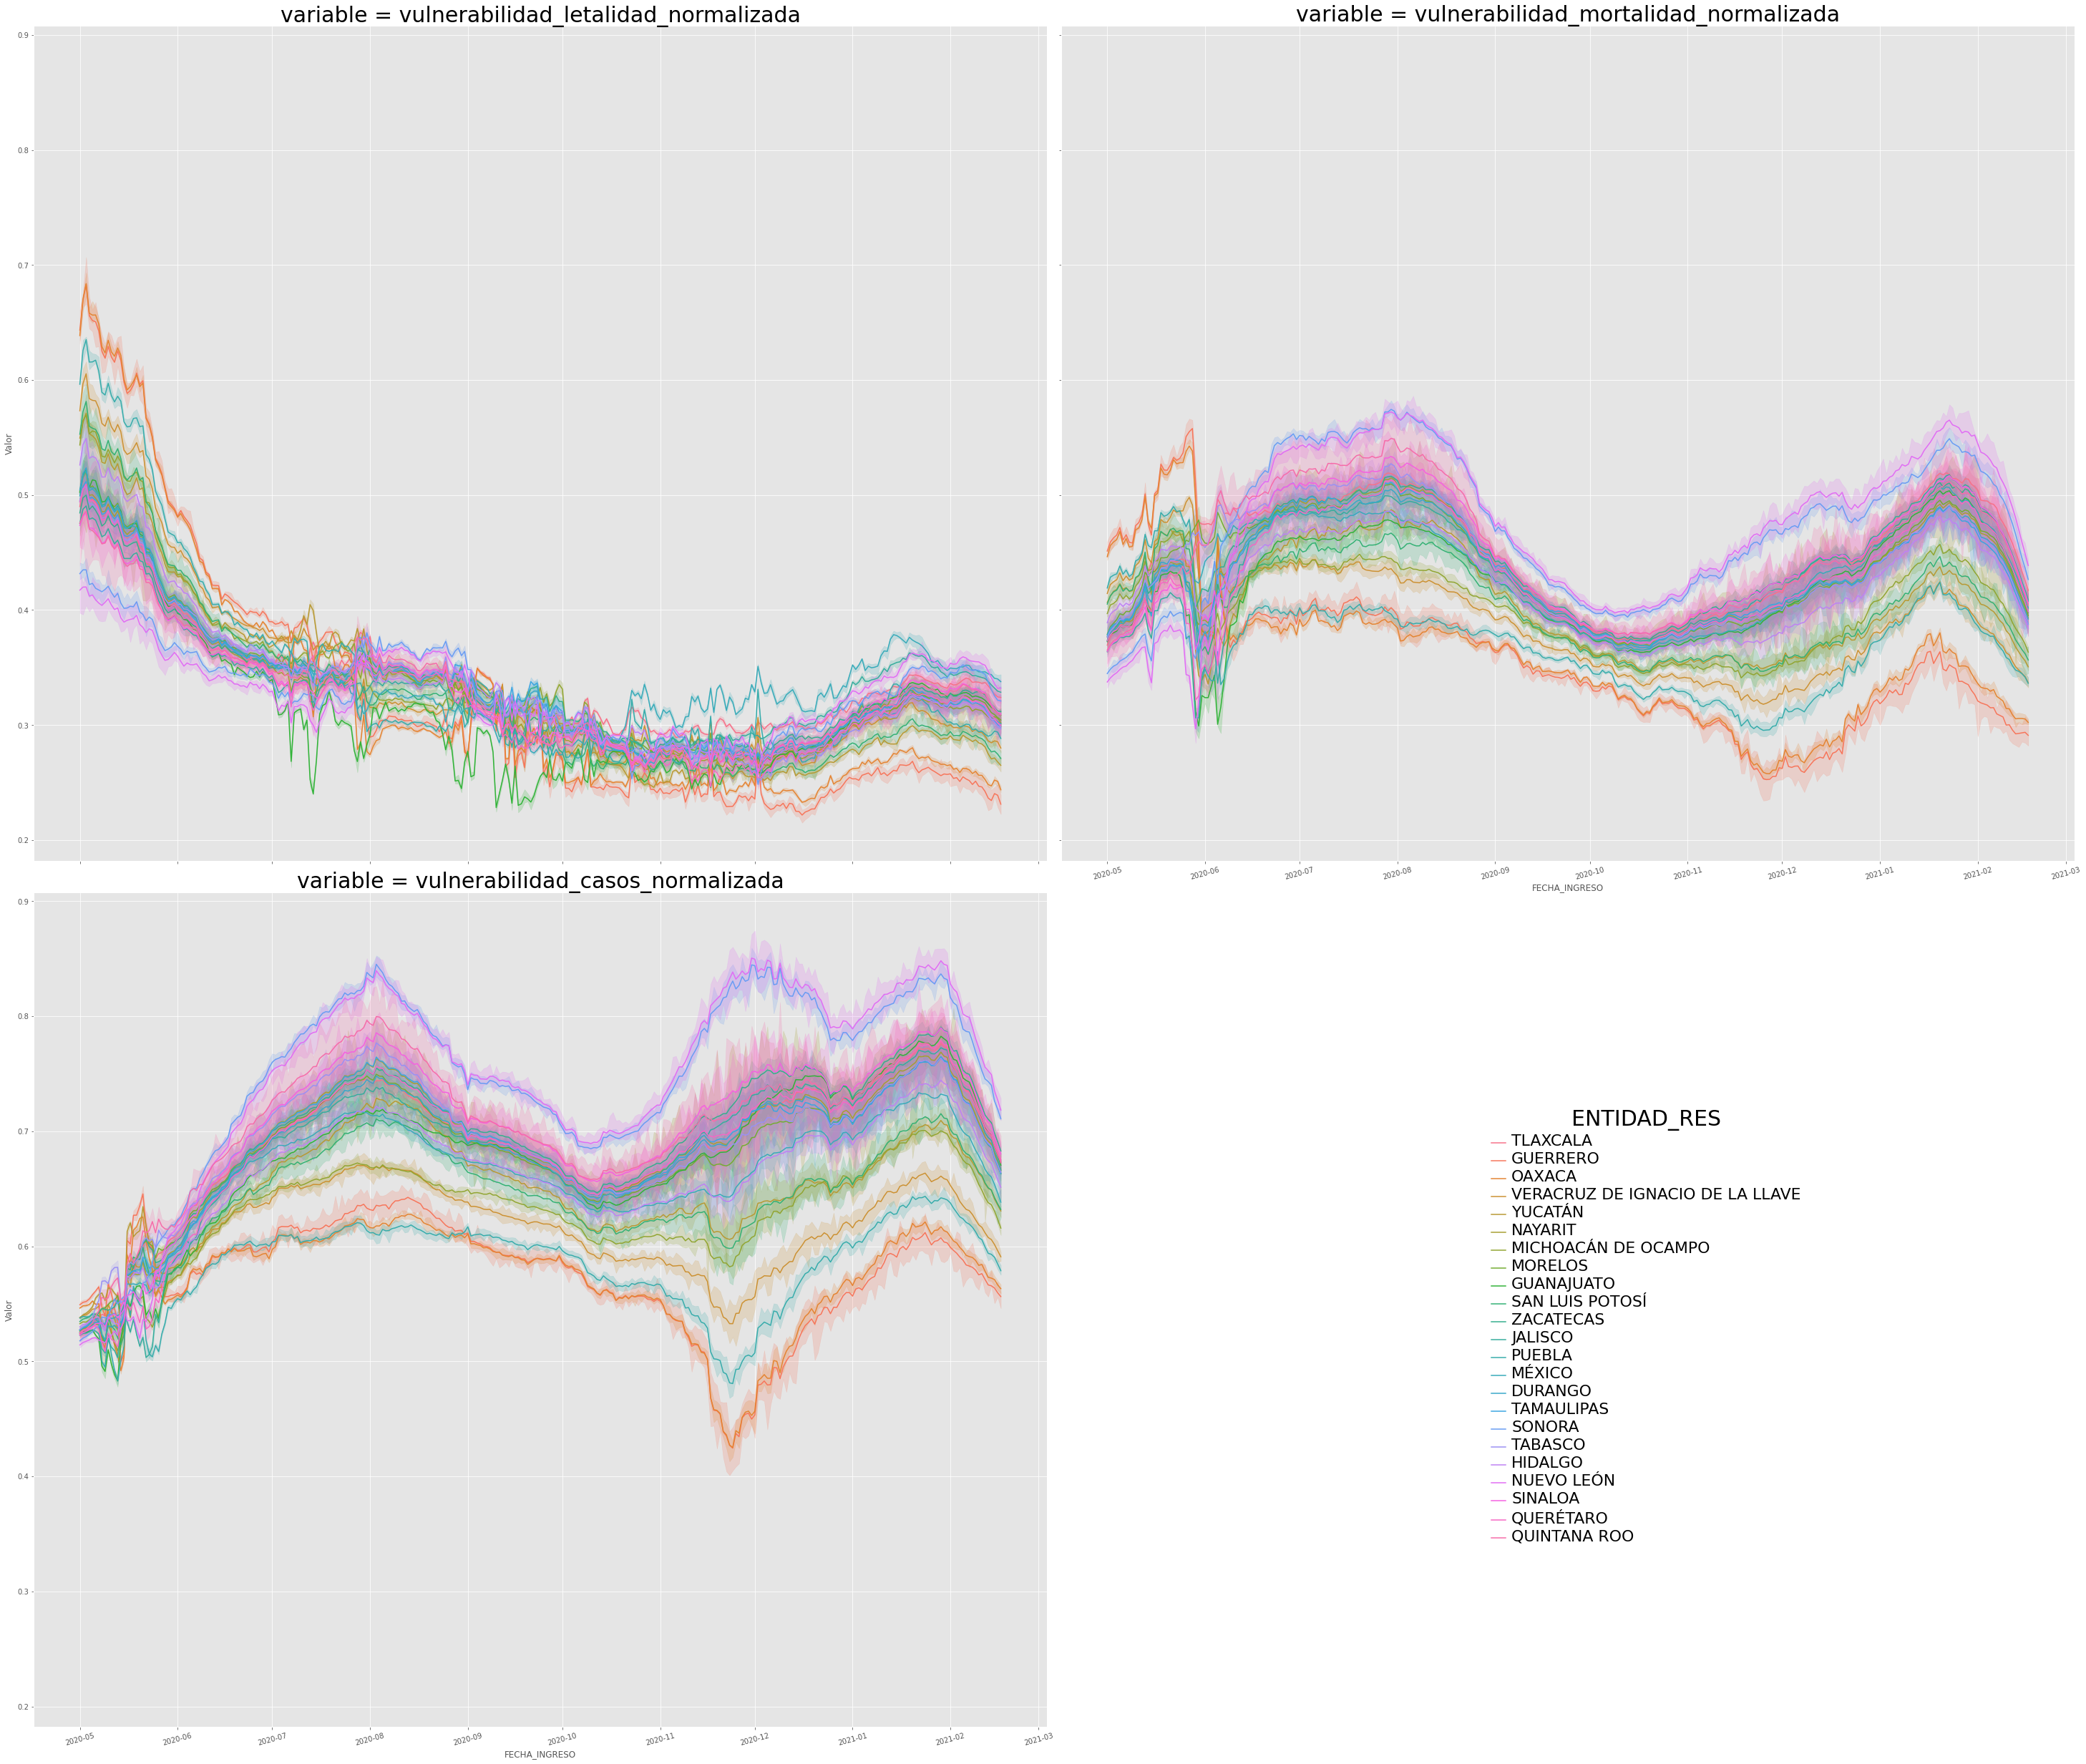

In [ ]:
g = sns.FacetGrid(compara_df, col="variable", height=17, aspect=1.2,
                  col_wrap=2, hue="ENTIDAD_RES")
g.map(sns.lineplot, 'FECHA_INGRESO', "Valor", palette='Spectral', n_boot=10)
g.set_xticklabels(rotation=15).add_legend()
g.set_titles(size=30)
plt.setp(g._legend.get_title(), fontsize=30)
plt.setp(g._legend.get_texts(), fontsize=22)
g._legend.set_bbox_to_anchor((0.8, 0.25))
plt.savefig('img/comparacion_series_vulnerabilidad.png', bbox_inches='tight')
plt.show()

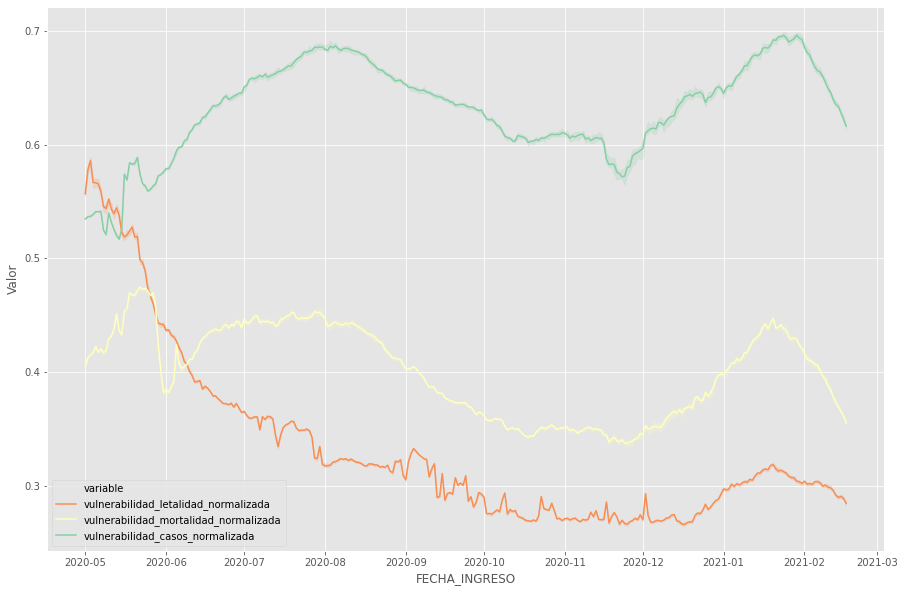

In [ ]:
compara_cdmx = compara_df[compara_df.ENTIDAD_RES == '09']
fig, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(data=compara_df,
             x='FECHA_INGRESO', y=f'Valor', palette='Spectral',
             hue='variable',
             n_boot=10)
plt.savefig('img/comparacion_vulnerabilidad_cdmx.png', bbox_inches='tight')

### Mapas

Vamos a hacer mapas para una fecha fija: 15 de febrero de 2021

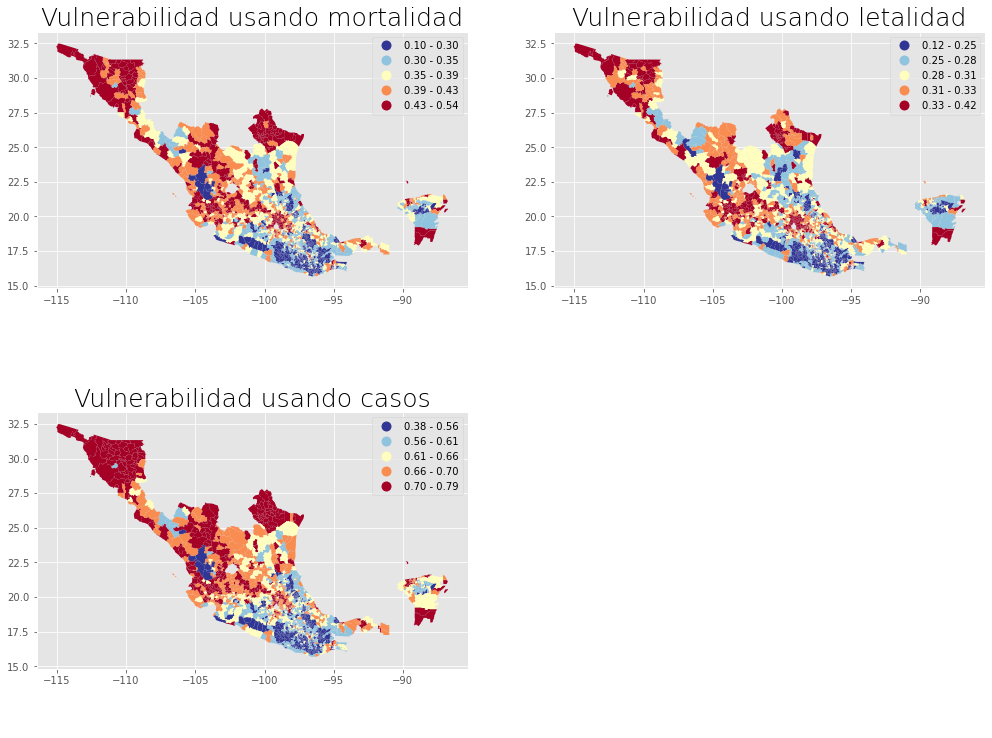

In [ ]:
fecha_analisis = pd.to_datetime('21-02-15', yearfirst=True)
mapa_vulnerabilidad_mortalidad_df = vulnerabilidad_pls_mortalidad[vulnerabilidad_pls_mortalidad.dia_ajuste == fecha_analisis]
mapa_vulnerabilidad_letalidad_df = vulnerabilidad_pls_letalidad[vulnerabilidad_pls_letalidad.dia_ajuste == fecha_analisis]
mapa_vulnerabilidad_casos_df = vulnerabilidad_pls_casos[vulnerabilidad_pls_casos.dia_ajuste == fecha_analisis]

fig, ax = plt.subplots(2,2,figsize=(17, 14))
ax = ax.ravel()
fig_1 = mapa_vulnerabilidad_mortalidad_df.plot(column='vulnerabilidad_mortalidad_normalizada', 
                                cmap='RdYlBu_r',
                                scheme='Quantiles',
                                k=5,
                                ax=ax[0],
                                legend=True)
fig_1.set_title('Vulnerabilidad usando mortalidad', \
          fontdict={'fontsize': '25', 'fontweight' : '3'})

fig_2 = mapa_vulnerabilidad_letalidad_df.plot(column='vulnerabilidad_letalidad_normalizada', 
                                cmap='RdYlBu_r',
                                scheme='Quantiles',
                                k=5,
                                ax=ax[1],
                                legend=True)
fig_2.set_title('Vulnerabilidad usando letalidad', \
          fontdict={'fontsize': '25', 'fontweight' : '3'})

fig_3 = mapa_vulnerabilidad_casos_df.plot(column='vulnerabilidad_casos_normalizada', 
                                cmap='RdYlBu_r',
                                scheme='Quantiles',
                                k=5,
                                ax=ax[2],
                                legend=True)
fig_3.set_title('Vulnerabilidad usando casos', \
          fontdict={'fontsize': '25', 'fontweight' : '3'})
ax[3].axis("off")
plt.subplots_adjust(hspace = .00001)
plt.savefig('img/mapas_comparacion_vulnerabilidad.png', bbox_inches='tight')
plt.show()

## Importancia de variables

In [ ]:
modelos_letalidad_pls = modelos_letalidad[modelos_letalidad.modelo == 'PLS']
modelos_letalidad_pls['mediana'] = (modelos_letalidad_pls
                                .groupby('caracteristica')['coef']
                                .transform('median'))
modelos_mortalidad_pls = modelos_mortalidad[modelos_mortalidad.modelo == 'PLS']
modelos_mortalidad_pls['mediana'] = (modelos_mortalidad_pls
                                .groupby('caracteristica')['coef']
                                .transform('median'))
modelos_casos_pls = modelos_casos[modelos_casos.modelo == 'PLS']
modelos_casos_pls['mediana'] = (modelos_casos_pls
                                .groupby('caracteristica')['coef']
                                .transform('median'))

### Comparación global

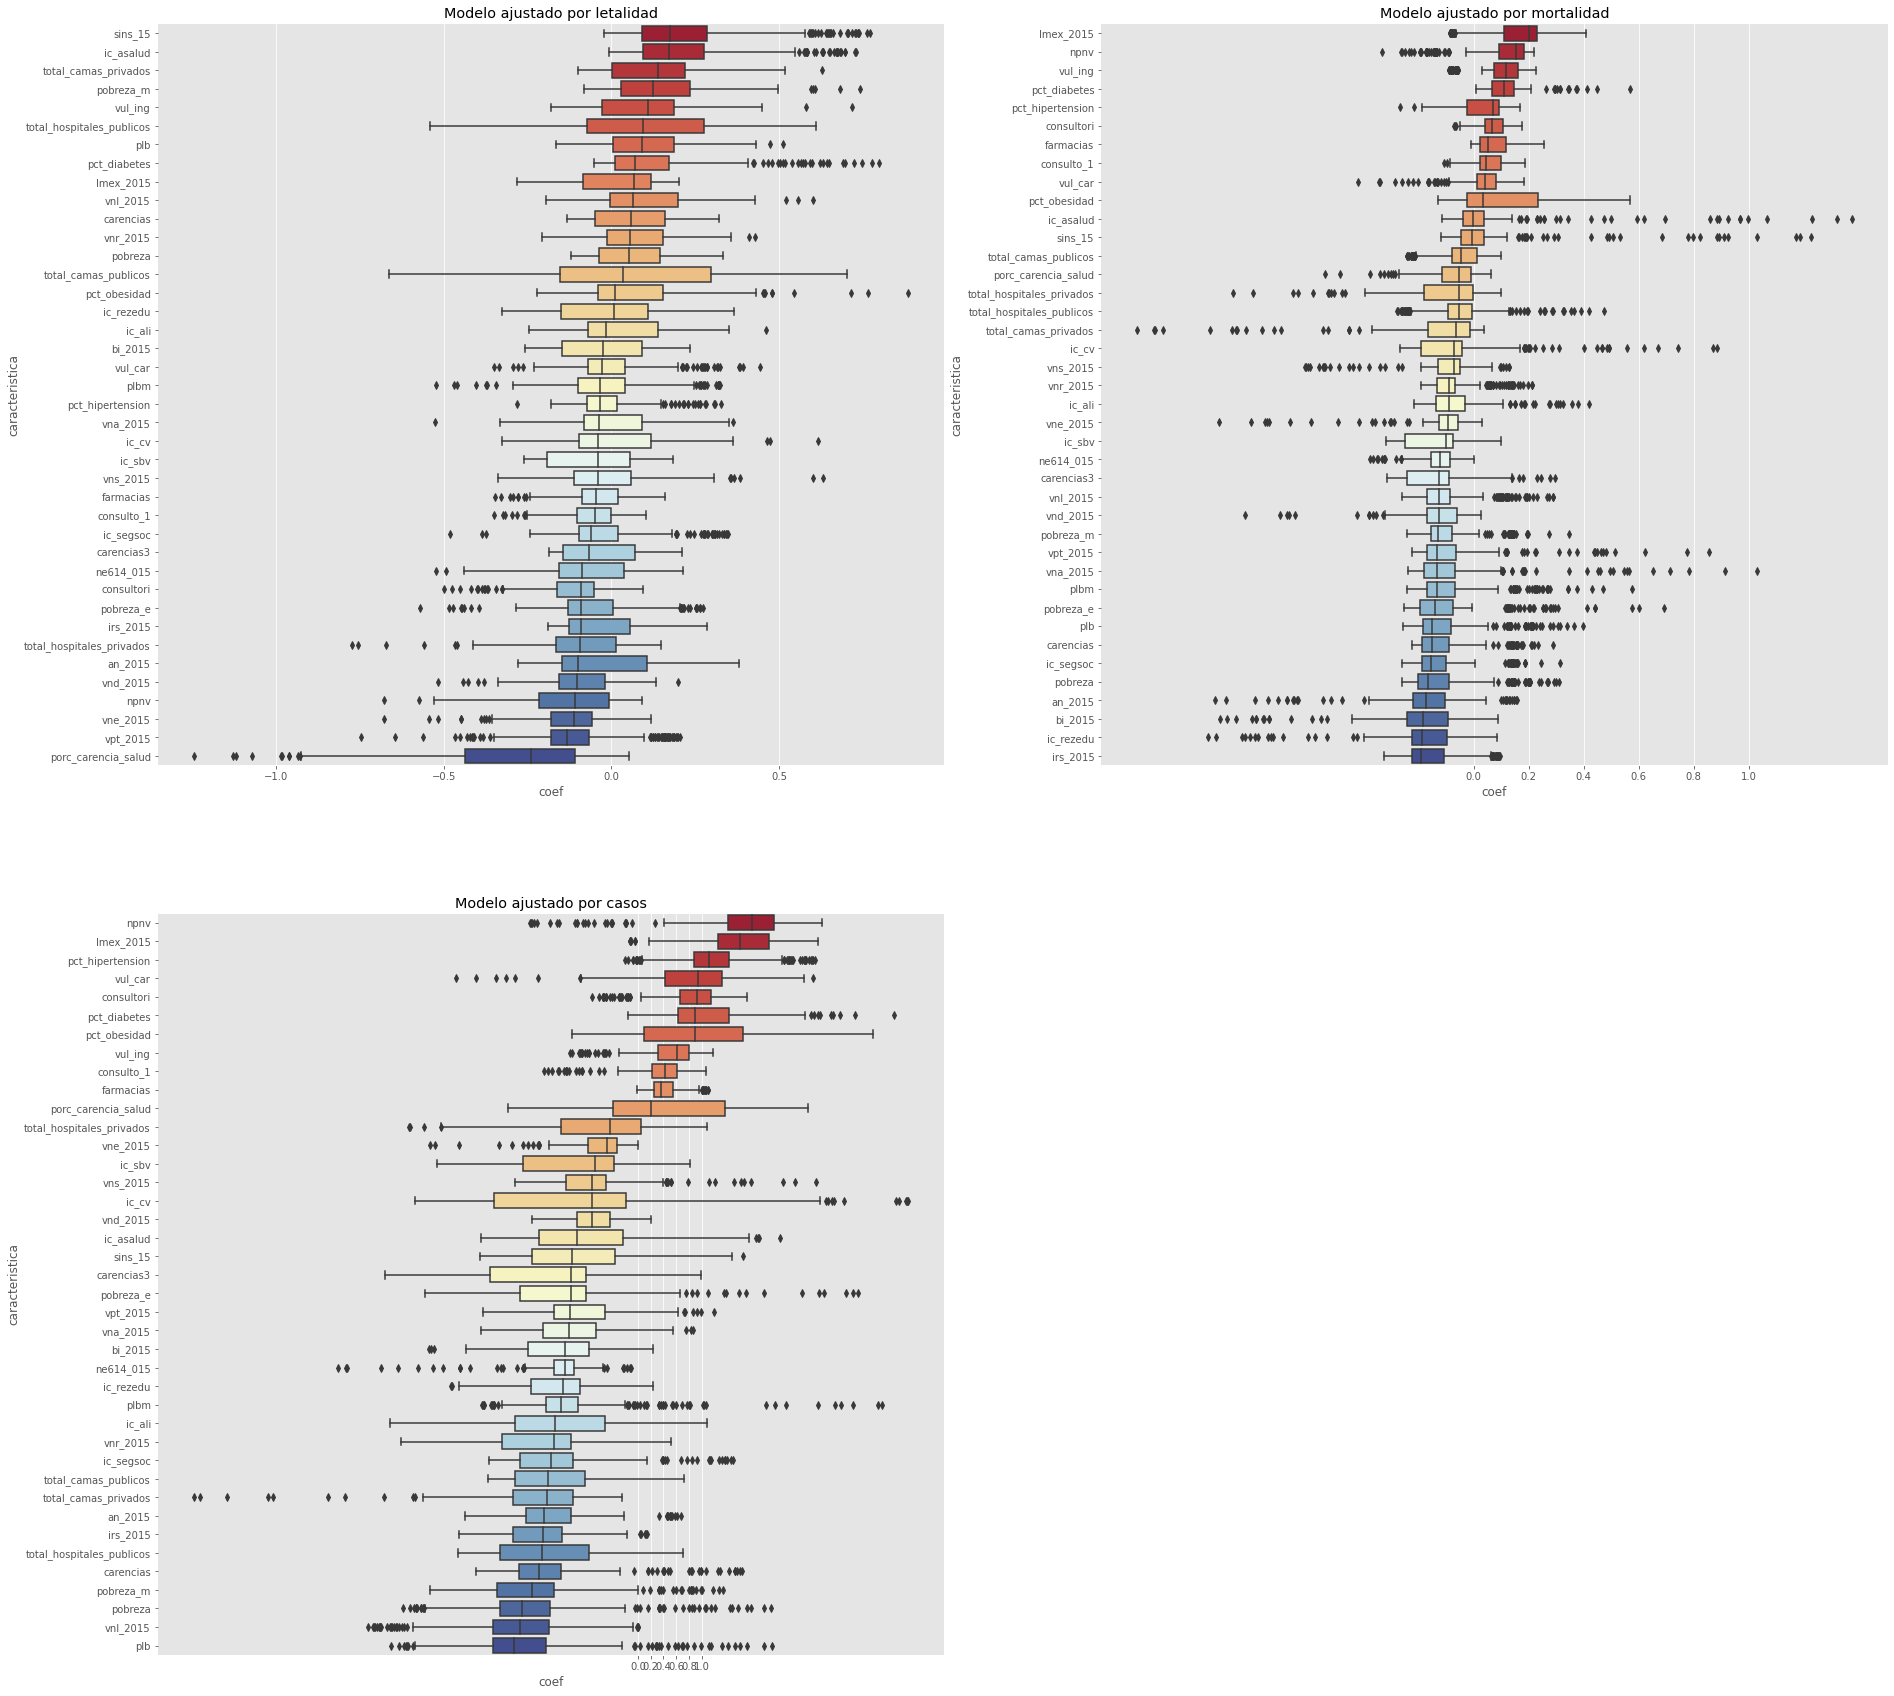

In [ ]:
f, ax = plt.subplots(2,2,figsize=(31, 30))
ax = ax.ravel()
sns.boxplot(y="caracteristica", x="coef",
            data=modelos_letalidad_pls.sort_values(by='mediana', ascending=False),
            palette='RdYlBu',
            ax=ax[0]).set(title="Modelo ajustado por letalidad")
sns.despine(trim=True, left=True)
sns.boxplot(y="caracteristica", x="coef",
            data=modelos_mortalidad_pls.sort_values(by='mediana', ascending=False),
            palette='RdYlBu',
            ax=ax[1]).set(title="Modelo ajustado por mortalidad")
sns.despine(trim=True, left=True)
sns.boxplot(y="caracteristica", x="coef",
            data=modelos_casos_pls.sort_values(by='mediana', ascending=False),
            palette='RdYlBu',
            ax=ax[2]).set(title="Modelo ajustado por casos")
sns.despine(trim=True, left=True)
ax[3].axis("off")
plt.savefig('img/comparacion_importancias_globales.png', bbox_inches='tight')

### Series de tiempo

In [ ]:
modelos_letalidad_pls['variable'] = 'Letalidad'
modelos_mortalidad_pls['variable'] = 'Mortalidad'
modelos_casos_pls['variable'] = 'Casos'
modelos_combinados = pd.concat([modelos_letalidad_pls, modelos_mortalidad_pls, modelos_casos_pls])
modelos_combinados.head()

caracteristica      coef dia_ajuste modelo   mediana   variable
0          ic_cv  0.172156 2020-05-01    PLS -0.038779  Letalidad
1       vns_2015  0.127966 2020-05-01    PLS -0.040197  Letalidad
2      pobreza_m  0.272940 2020-05-01    PLS  0.125106  Letalidad
3      carencias  0.287090 2020-05-01    PLS  0.059771  Letalidad
4      lmex_2015 -0.227245 2020-05-01    PLS  0.067729  Letalidad

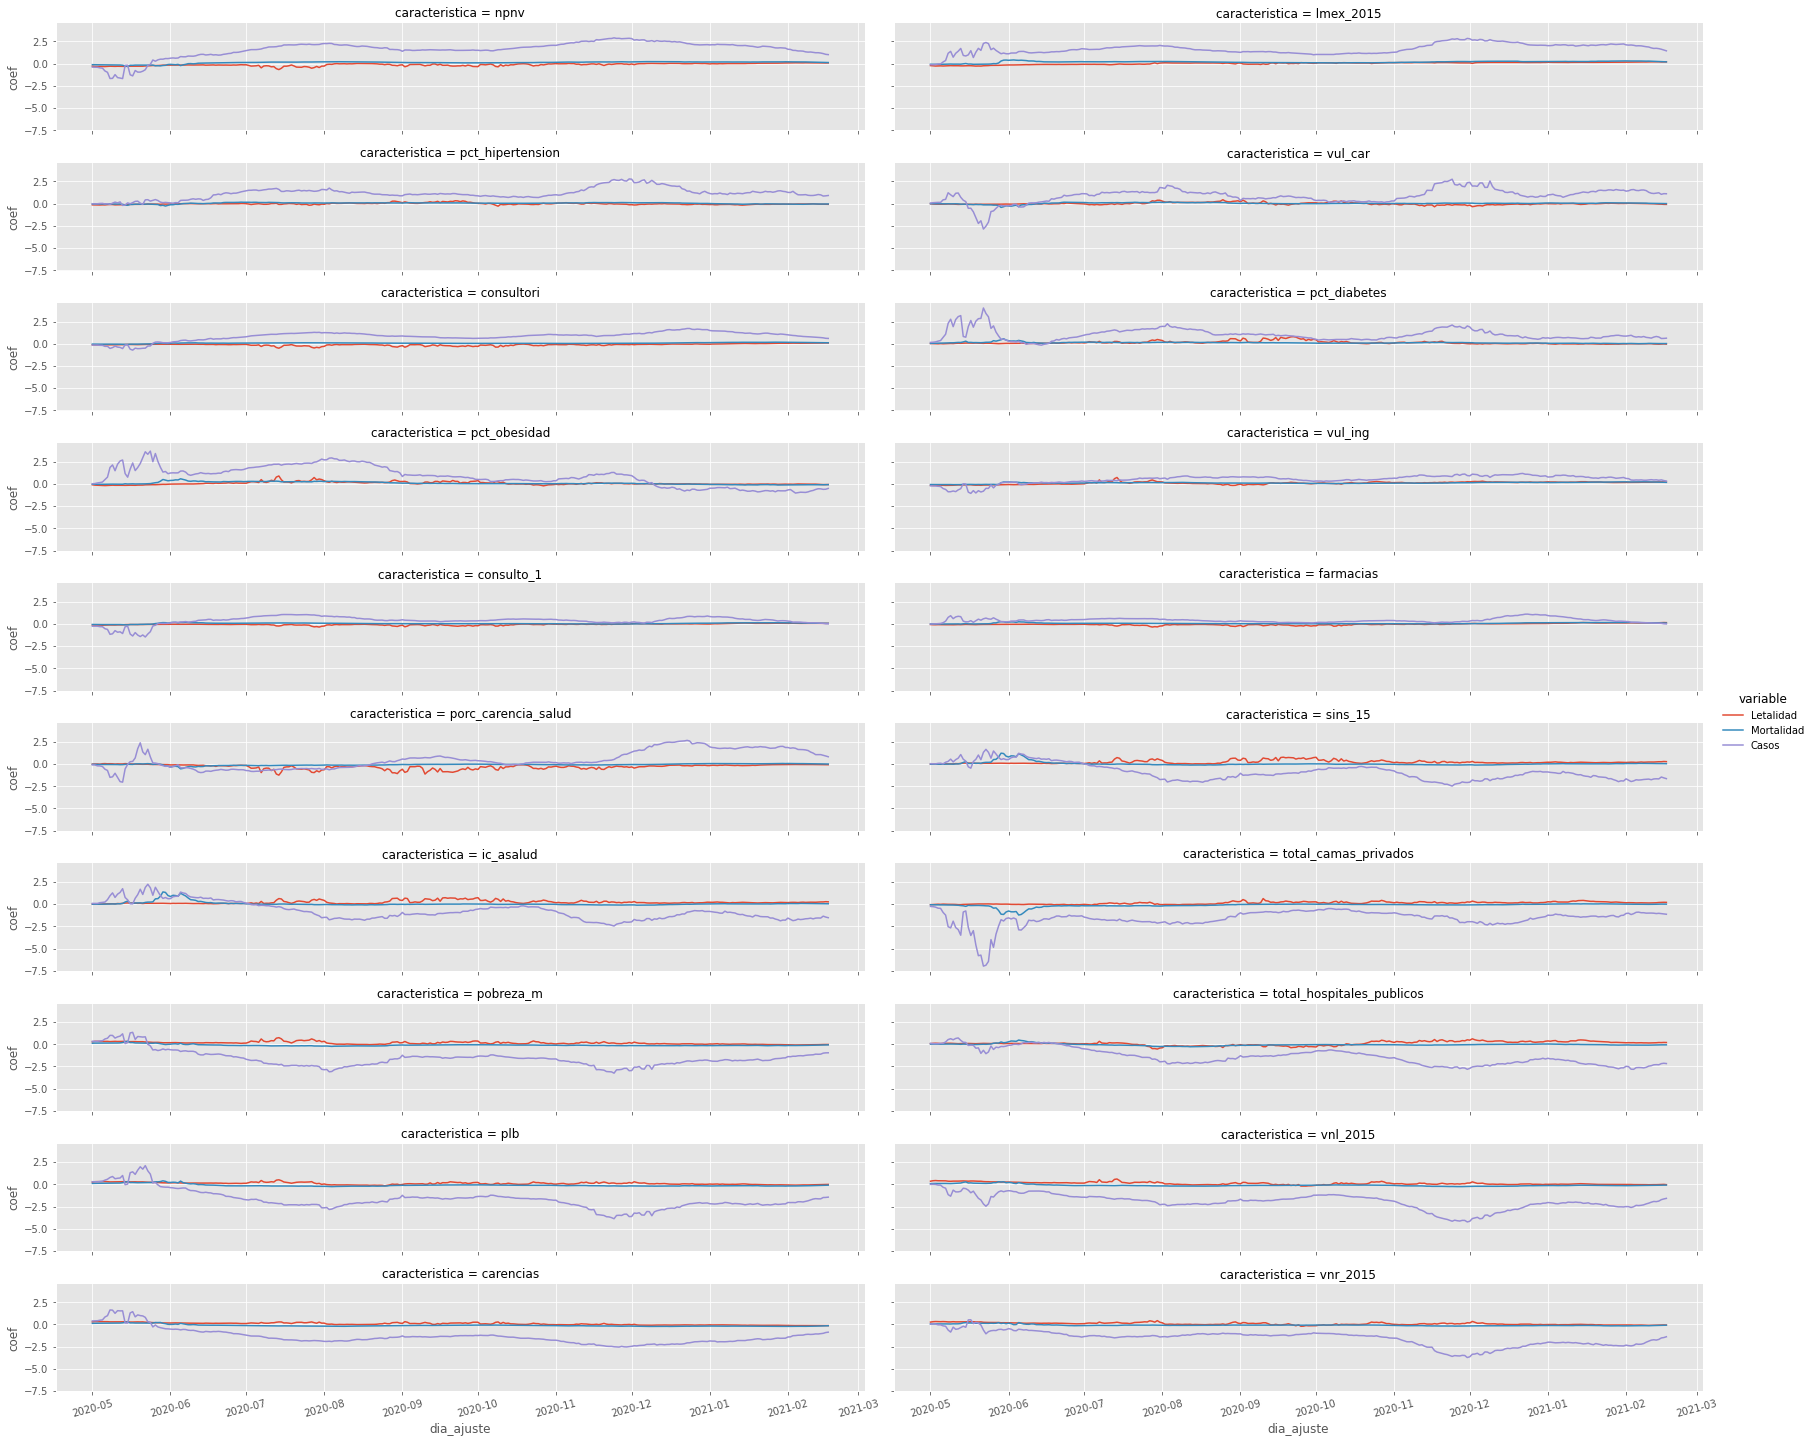

In [ ]:
orden_plots = modelos_combinados.sort_values(by='mediana', ascending=False)['caracteristica'].drop_duplicates()

g = sns.FacetGrid(modelos_combinados, col="caracteristica", height=2, aspect=6,
                  col_wrap=2, col_order=orden_plots[:20], hue="variable")
g.map(sns.lineplot, 'dia_ajuste', "coef")
g.set_xticklabels(rotation=15).add_legend()
plt.savefig('img/serie_importancia.png', bbox_inches='tight')
plt.show()
